# Analysis and operation suggestions for HealthyRide
## Group 15 member:
### Elaine Zhang, yizhang5@andrew.cmu.edu
### Xintong Zheng, xzheng3@andrew.cmu.edu
### Xi Yan, xiyan@andrew.cmu.edu


This project is about analysis and operation suggestions for HealthyRide. In this project, we split into 3 questions to better analyze HealthyRide.
1. How long do users usually ride based on other features?
2. How can we determine usertypes based on other features?
3. What is the influence of weather on trip duration? Weather is examined by average wind speed, precipitation, maximum temperature, minimum temperature, and average temperature.

For the first two questions, we perform classifications, and for the third question, we used clustering to try to answer these questions.
To begin with the project, we first do data processing to import and merge datasets.

**Due to that we have a very large dataset (200,000+ rows), please allow some time (45 minutes, mainly because of randomforest) to run the model fitting, we are sorry that it takes such long time to run the model, but it is an inevitable action to do to during model selection process to generate high quality of validation. We want to apologize again for the inconvenience.**


In [246]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
%matplotlib inline
plt.style.use('seaborn-white')
# Import ML packages
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
#from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import r2_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from IPython.display import Image
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from yellowbrick.features import Rank2D

# Implementation -- Data processing

### Read and clean weather data
The weather data is retrieved from [National Centers for Environmental Information](https://www.ncdc.noaa.gov/cdo-web/search), ranged from Jan.1 2017 to Dec.31 2019, of a weather station located at Pittsburgh, PA, USA.

In [247]:
# Read weather csv file
weather = pd.read_csv("pit_weather.csv")
# Select only 5 columns from the initial dataset
weather = weather[['DATE', 'AWND', 'PRCP', 'TMAX', 'TMIN']]
# Calculate the average temperature of the day
weather['TAVG'] = weather[['TMAX', 'TMIN']].mean(axis=1)
# Show if there are any missing values
weather.info()
# However, we will not drop the NaN values now for the convenience of merging dataset
weather.isnull().sum(axis=0)
# Print the first 5 rows of the dataset
weather.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    1095 non-null   object 
 1   AWND    1092 non-null   float64
 2   PRCP    1094 non-null   float64
 3   TMAX    1093 non-null   float64
 4   TMIN    1093 non-null   float64
 5   TAVG    1093 non-null   float64
dtypes: float64(5), object(1)
memory usage: 51.5+ KB


,DATE,AWND,PRCP,TMAX,TMIN,TAVG
0,2017-01-01,5.82,0.03,44.0,32.0,38.0
1,2017-01-02,7.16,0.09,46.0,36.0,41.0
2,2017-01-03,6.93,0.76,50.0,42.0,46.0
3,2017-01-04,15.66,0.04,45.0,21.0,33.0
4,2017-01-05,8.72,0.06,23.0,18.0,20.5


### Read and clean ride rentals data
The ride rental data is retrieved from [Western Pennsylvania Regional Data Center](https://data.wprdc.org/dataset/healthyride-trip-data), since we are using 2017-2019 data, and the data is a .csv file quarterly. We have to combine 12 .csv data first in order to finish the cleaning.

In [248]:
ride = pd.DataFrame(data=None)
for i in range(7,10):
    for j in range(1,5):
        ride_1 = pd.read_csv("healthy-ride-rentals-201{}-q{}.csv".format(i, j), low_memory=False)
        # drop the lines with NA
        ride_1 = ride_1.dropna(axis=0)
        # copy the column with date
        ride_1["tmp"] = ride_1["Starttime"]
        # starttime and stoptime delete the date
        ride_1["Starttime"] = ride_1["Starttime"].apply(lambda x: str(x).split(" ")[1])
        # convert starttime to minutes
        ride_1["Starttime"] = ride_1["Starttime"].apply(lambda x: int(str(x).split(":")[0]) * 60 + int(str(x).split(":")[1]))
        ride_1["Stoptime"] = ride_1["Stoptime"].apply(lambda x: str(x).split(" ")[1])
        # convert stoptime to minutes
        ride_1["Stoptime"] = ride_1["Stoptime"].apply(lambda x: int(str(x).split(":")[0]) * 60 + int(str(x).split(":")[1]))
        # extract date to a new column and then merge with weather dataset
        ride_1["DATE"] = ride_1["tmp"].apply(lambda x: str(str(x).split("/")[2]).split(" ")[0] + "-" + str(x).split("/")[0]+ "-"  + str(x).split("/")[1])
        # adjust the format
        ride_1["DATE"] = pd.to_datetime(ride_1["DATE"]).apply(lambda x: str(x).split(" ")[0])
        # delete the temp column
        del ride_1["tmp"]

        # add each subdataset
        ride = pd.concat([ride, ride_1])
ride.head(5)

,Trip id,Starttime,Stoptime,Bikeid,Tripduration,From station id,From station name,To station id,To station name,Usertype,DATE
0,25723960.0,508,510,70478.0,110.0,1043.0,S Millvale Ave & Centre Ave,1044.0,Zulema St & Coltart Ave,Subscriber,2017-01-01
1,25724207.0,593,600,70439.0,426.0,1014.0,Ridge Ave & Brighton Rd (CCAC),1012.0,North Shore Trail & Fort Duquesne Bridge,Customer,2017-01-01
2,25724297.0,621,646,70440.0,1498.0,1019.0,42nd St & Butler St,1012.0,North Shore Trail & Fort Duquesne Bridge,Subscriber,2017-01-01
3,25724391.0,663,690,70002.0,1581.0,1019.0,42nd St & Butler St,1013.0,Isabella St & Federal St (PNC Park),Customer,2017-01-01
4,25724479.0,703,729,70024.0,1563.0,1018.0,Butler St & Stanton Ave,1013.0,Isabella St & Federal St (PNC Park),Customer,2017-01-01


### Merge ride dataframe with weather dataframe based on DATE

In [249]:
df_merged = pd.merge(ride, weather, on='DATE')
df_merged.info()
# Show how many rows have empty values
df_merged.isnull().sum(axis=0)
# Drop rows which contain NaN values
df_merged = df_merged.dropna()
# Drop not useful columns
df_merged = df_merged.drop(['Trip id', 'Bikeid','From station name', 'To station name'], axis=1)
# Convert Usertype from categorical to dummy variable 0(customer) and 1(subscriber)
df_merged['Usertype'] = df_merged['Usertype'].astype('category').cat.codes
# Show top 5 rows of the dataset
df_merged.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227290 entries, 0 to 227289
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Trip id            227290 non-null  float64
 1   Starttime          227290 non-null  int64  
 2   Stoptime           227290 non-null  int64  
 3   Bikeid             227290 non-null  float64
 4   Tripduration       227290 non-null  float64
 5   From station id    227290 non-null  float64
 6   From station name  227290 non-null  object 
 7   To station id      227290 non-null  float64
 8   To station name    227290 non-null  object 
 9   Usertype           227290 non-null  object 
 10  DATE               227290 non-null  object 
 11  AWND               227006 non-null  float64
 12  PRCP               226736 non-null  float64
 13  TMAX               227215 non-null  float64
 14  TMIN               227215 non-null  float64
 15  TAVG               227215 non-null  float64
dtypes:

,Starttime,Stoptime,Tripduration,From station id,To station id,Usertype,DATE,AWND,PRCP,TMAX,TMIN,TAVG
0,508,510,110.0,1043.0,1044.0,1,2017-01-01,5.82,0.03,44.0,32.0,38.0
1,593,600,426.0,1014.0,1012.0,0,2017-01-01,5.82,0.03,44.0,32.0,38.0
2,621,646,1498.0,1019.0,1012.0,1,2017-01-01,5.82,0.03,44.0,32.0,38.0
3,663,690,1581.0,1019.0,1013.0,0,2017-01-01,5.82,0.03,44.0,32.0,38.0
4,703,729,1563.0,1018.0,1013.0,0,2017-01-01,5.82,0.03,44.0,32.0,38.0


### Pre data exploration: visualization

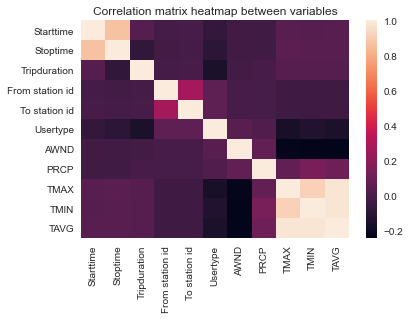

In [250]:
# Data visualization plots (first)
# This plot try to see the correlation between each features
corr = df_merged.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,).set_title('Correlation matrix heatmap between variables')
plt.show()

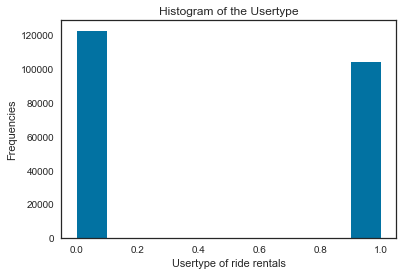

In [251]:
# Data visualization plots (second)
# This plot try to see the distribution of Usertype for ride rentals
plt.hist(df_merged['Usertype'])
plt.xlabel('Usertype of ride rentals')
plt.ylabel('Frequencies')
plt.title('Histogram of the Usertype')
plt.show()

After this, we are all set to analyze each question separately! We then perform each question's analysis by segment, with data exploration, model traning anselection, validation, performance metrics, conlusions step by step.

# First question Q1 analysis: How long do users usually ride based on other features?

### Q1 Implementation: Data exploration: Visualization

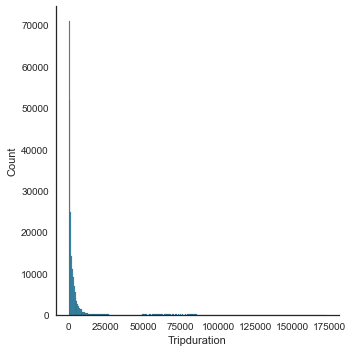

In [252]:
df_q1 = df_merged
# show the distribution of duration
# This plot tries to see the distribution of Usertype for ride rentals
sns.displot(df_q1['Tripduration'], bins = 300)

<Figure size 864x432 with 0 Axes>

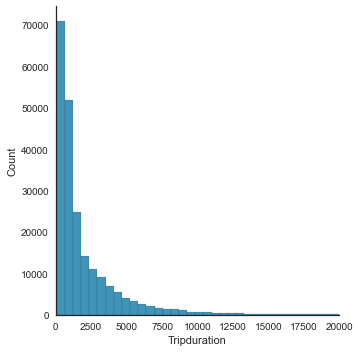

In [253]:
# zoom in the most hense area to select the general proper step size
plt.figure(figsize = (12, 6))
sns.displot(df_q1['Tripduration'], bins = 300)
plt.xlim(0, 20000)
plt.show()

As is shown in the figure, the distribution is highly skewed and most of the users ride within 2500 seconds. It is not proper to have a very large step size, thus most of the data will fall into one class.
So we can split the duration into 5 classes with the 3 step sizes: 600, 900, and 1200

In [254]:
# categorize trip duration into 5 classes
# the function is to test the best stepsize for 5 classes
def cat_type(x, stepsize):
    if x <= stepsize:
        a='1'
    elif x > stepsize and x <= stepsize * 2:
        a='2'
    elif x > stepsize * 2 and x <= stepsize * 3:
        a='3'
    elif x > stepsize * 3 and x <= stepsize * 4:
        a='4'
    else:
        a='5'
    return a

### Q1 Implementation: Model Training and Selection based on tuning, validation, and performance metrics

### First Model: KNN
**Due to that we have a very large dataset (200,000+ rows), please allow some time to run the model fitting, thank you**

Time interval for duration is: 600 seconds
              precision    recall  f1-score   support

           1      0.874     0.928     0.900     19797
           2      0.831     0.819     0.825     16831
           3      0.821     0.791     0.805      7752
           4      0.838     0.750     0.792      4433
           5      0.986     0.974     0.980     19123

    accuracy                          0.887     67936
   macro avg      0.870     0.852     0.860     67936
weighted avg      0.886     0.887     0.886     67936



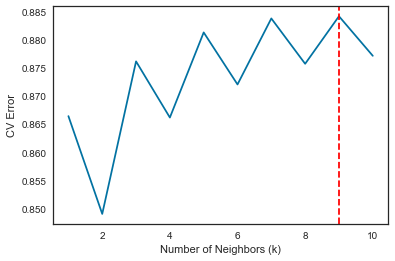

              precision    recall  f1-score   support

           1      0.869     0.940     0.903     19797
           2      0.834     0.819     0.827     16831
           3      0.824     0.780     0.801      7752
           4      0.857     0.742     0.795      4433
           5      0.988     0.973     0.981     19123

    accuracy                          0.888     67936
   macro avg      0.875     0.851     0.861     67936
weighted avg      0.888     0.888     0.887     67936

---------------------------------------------------------------------------
Time interval for duration is: 900 seconds
              precision    recall  f1-score   support

           1      0.935     0.978     0.956     30155
           2      0.889     0.843     0.866     14225
           3      0.883     0.830     0.856      6203
           4      0.871     0.863     0.867      4403
           5      0.984     0.966     0.975     12950

    accuracy                          0.927     67936
   macro avg

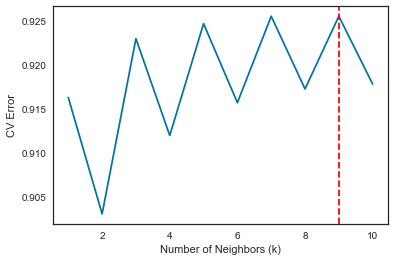

              precision    recall  f1-score   support

           1      0.930     0.987     0.958     30155
           2      0.903     0.836     0.868     14225
           3      0.894     0.827     0.859      6203
           4      0.876     0.871     0.873      4403
           5      0.988     0.963     0.975     12950

    accuracy                          0.929     67936
   macro avg      0.918     0.897     0.907     67936
weighted avg      0.929     0.929     0.928     67936

---------------------------------------------------------------------------
Time interval for duration is: 1200 seconds
              precision    recall  f1-score   support

           1      0.963     0.987     0.975     36628
           2      0.922     0.873     0.897     12185
           3      0.903     0.902     0.903      6173
           4      0.889     0.885     0.887      3757
           5      0.987     0.962     0.974      9193

    accuracy                          0.950     67936
   macro av

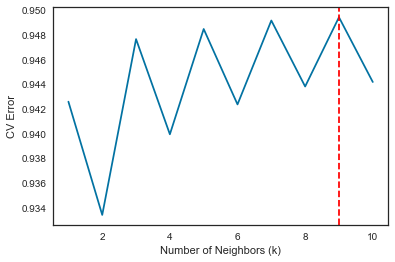

              precision    recall  f1-score   support

           1      0.959     0.991     0.975     36628
           2      0.931     0.865     0.897     12185
           3      0.908     0.909     0.908      6173
           4      0.903     0.880     0.891      3757
           5      0.988     0.961     0.974      9193

    accuracy                          0.950     67936
   macro avg      0.938     0.921     0.929     67936
weighted avg      0.950     0.950     0.950     67936

---------------------------------------------------------------------------


In [255]:
# try time interval: 600, 900, 1200
for i in range(600, 1500, 300):
    # split duration into 5 classes
    df_q1['dura_cat'] = df_q1['Tripduration'].apply(lambda x :cat_type(x, i))

    # split X and y
    X_q1 = df_q1.drop(['Tripduration', 'DATE', 'From station id', 'To station id', 'dura_cat'], axis=1)
    y_q1 = df_q1['dura_cat']

    # Set up train and test sets of data, train data is 70 percent of the dataset, and test is 30 percent.
    X_train_q1, X_test_q1, y_train_q1, y_test_q1 = train_test_split(X_q1, y_q1, test_size=0.3, random_state=1)

    # KNN for duration category
    knn_q1 = KNeighborsClassifier().fit(X_train_q1, y_train_q1)
    y_pred_q1 = knn_q1.predict(X_test_q1)

    print("Time interval for duration is: " + str(i) + " seconds")
    print(classification_report(y_test_q1, y_pred_q1, digits=3))

    # tune the model and try number of neighbors from 1 to 10
    neighbors = range(1, 11)
    knn_scores = []
    for i in neighbors:
        knn_q1 = KNeighborsClassifier(n_neighbors=i)
        CV_error = np.mean(cross_val_score(knn_q1, X_train_q1, y_train_q1, cv=10, scoring = 'accuracy'))
        knn_scores.append(CV_error)

    # plot the trend of k
    plt.plot(neighbors,knn_scores)
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("CV Error")
    plt.axvline(x=neighbors[knn_scores.index(max(knn_scores))],linestyle='--',color="red")
    plt.show()

    # show the result of tuned model
    knn = KNeighborsClassifier(n_neighbors=neighbors[knn_scores.index(max(knn_scores))]).fit(X_train_q1, y_train_q1)
    y_pred_q1 = knn.predict(X_test_q1)
    print(classification_report(y_test_q1, y_pred_q1, digits=3))
    print("---------------------------------------------------------------------------")

The general results of KNN are very well, with the average accuracy around 0.9.
When we tune the model, the accuracy gets improved except the one with step size = 1200s, maybe because the accuracy of 0.95 is too high to improve.

### Second Model: Naive Bayes

In [256]:
# try time interval: 600, 900, 1200
for i in range(600, 1500, 300):
    # split duration into 5 classes
    df_q1['dura_cat'] = df_q1['Tripduration'].apply(lambda x :cat_type(x, i))

    # split X and y
    X_q1 = df_q1.drop(['Tripduration', 'DATE', 'From station id', 'To station id', 'dura_cat'], axis=1)
    y_q1 = df_q1['dura_cat']

    # Set up train and test sets of data, train data is 70 percent of the dataset, and test is 30 percent.
    X_train_q1, X_test_q1, y_train_q1, y_test_q1 = train_test_split(X_q1, y_q1, test_size=0.3, random_state=1)

    # Naive Bayes
    modelNB = GaussianNB().fit(X_train_q1, y_train_q1)
    y_pred_q1 = modelNB.predict(X_test_q1)

    print("Time interval for duration is: " + str(i) + " seconds")
    print(classification_report(y_test_q1, y_pred_q1, digits=3, zero_division=1))
    print("---------------------------------------------------------------------------")

Time interval for duration is: 600 seconds
              precision    recall  f1-score   support

           1      0.450     0.568     0.502     19797
           2      0.315     0.220     0.259     16831
           3      0.182     0.003     0.006      7752
           4      1.000     0.000     0.000      4433
           5      0.487     0.790     0.603     19123

    accuracy                          0.443     67936
   macro avg      0.487     0.316     0.274     67936
weighted avg      0.432     0.443     0.381     67936

---------------------------------------------------------------------------
Time interval for duration is: 900 seconds
              precision    recall  f1-score   support

           1      0.630     0.788     0.700     30155
           2      0.233     0.012     0.023     14225
           3      1.000     0.000     0.000      6203
           4      1.000     0.000     0.000      4403
           5      0.337     0.767     0.468     12950

    accuracy           

The performances of Naive Bayes are very bad. The best of them is 0.522.
So Naive Bayes is not a good model for this problem.

### Third Model: Decision Tree

Time interval for duration is: 600 seconds
Mean CV score of 0.29, with a standard deviation of 0.01
Mean CV score of -1.81, with a standard deviation of 0.01
Accuracy of test dataset is: 0.29637245144389157


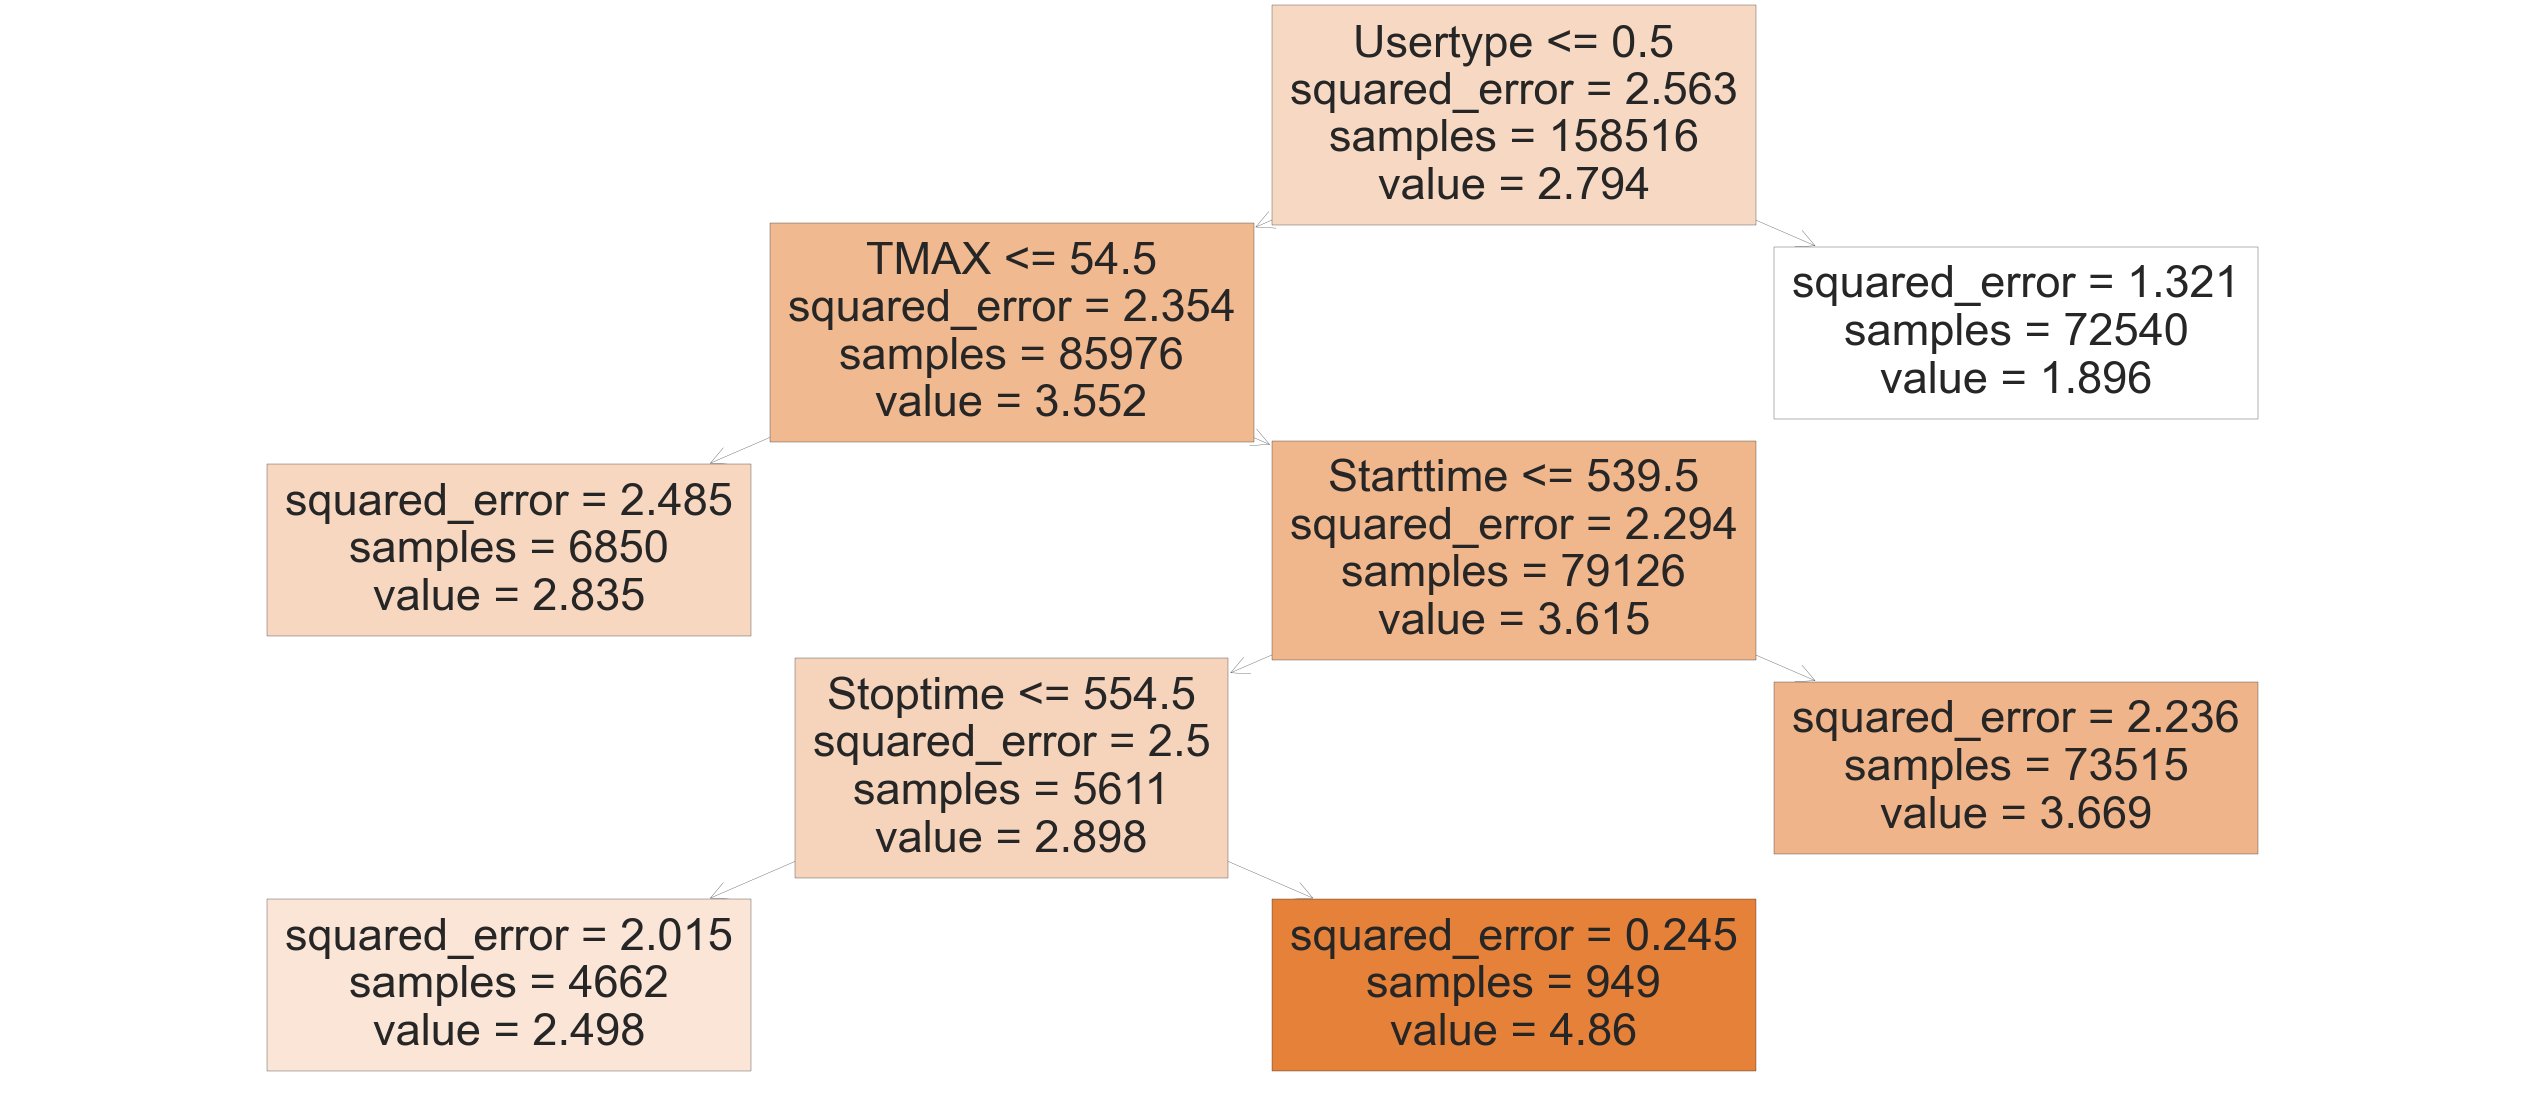

---------------------------------------------------------------------------
Time interval for duration is: 900 seconds
Mean CV score of 0.27, with a standard deviation of 0.01
Mean CV score of -1.74, with a standard deviation of 0.01
Accuracy of test dataset is: 0.275413772840744


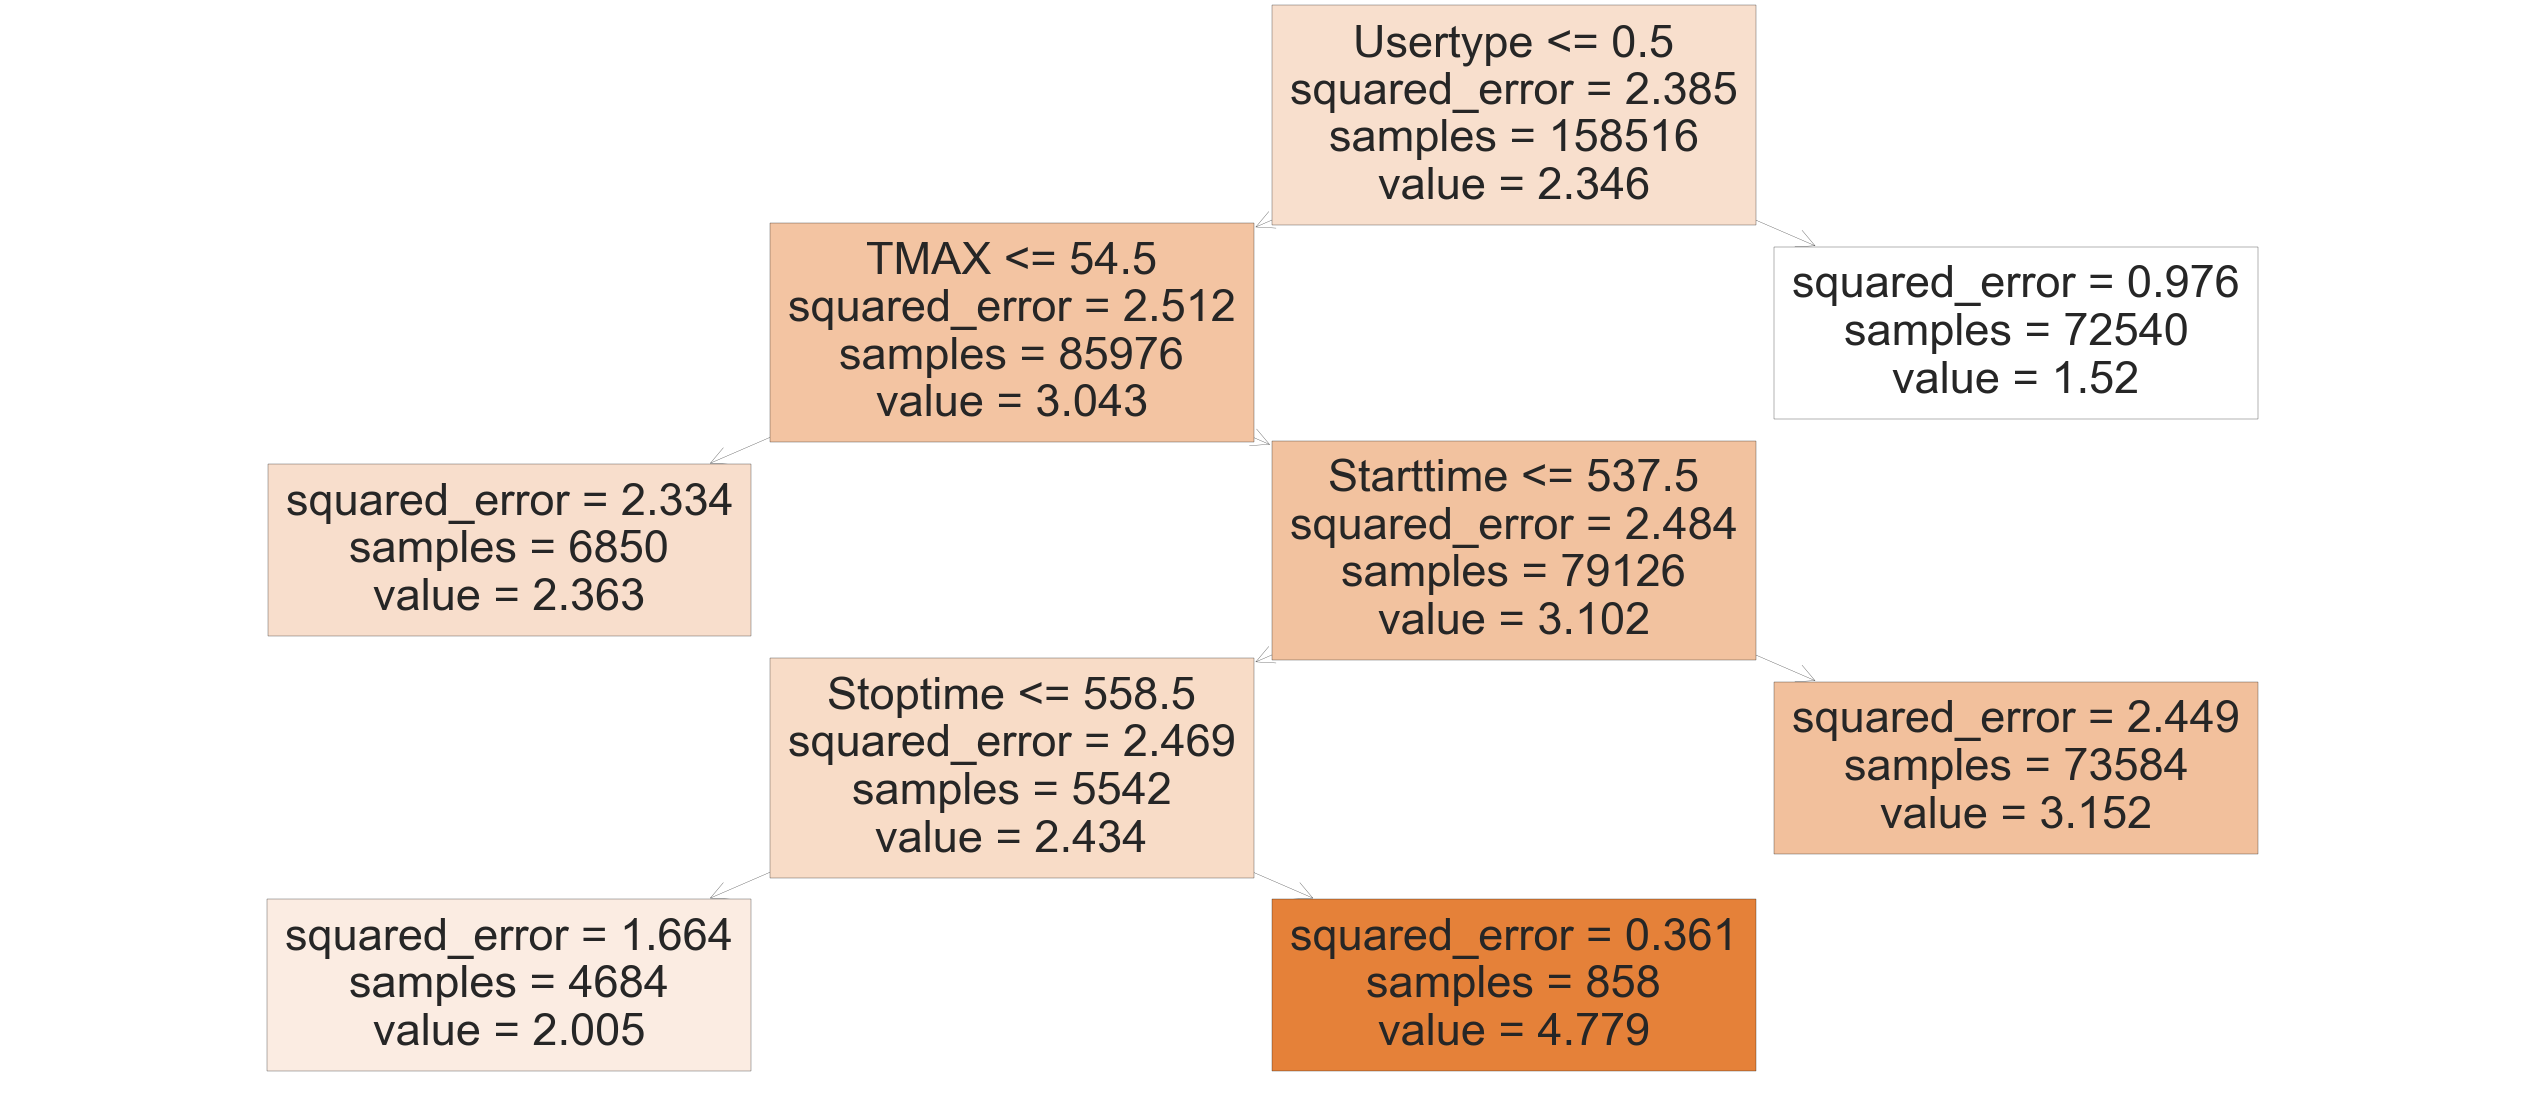

---------------------------------------------------------------------------
Time interval for duration is: 1200 seconds
Mean CV score of 0.24, with a standard deviation of 0.01
Mean CV score of -1.57, with a standard deviation of 0.01
Accuracy of test dataset is: 0.2442367880073505


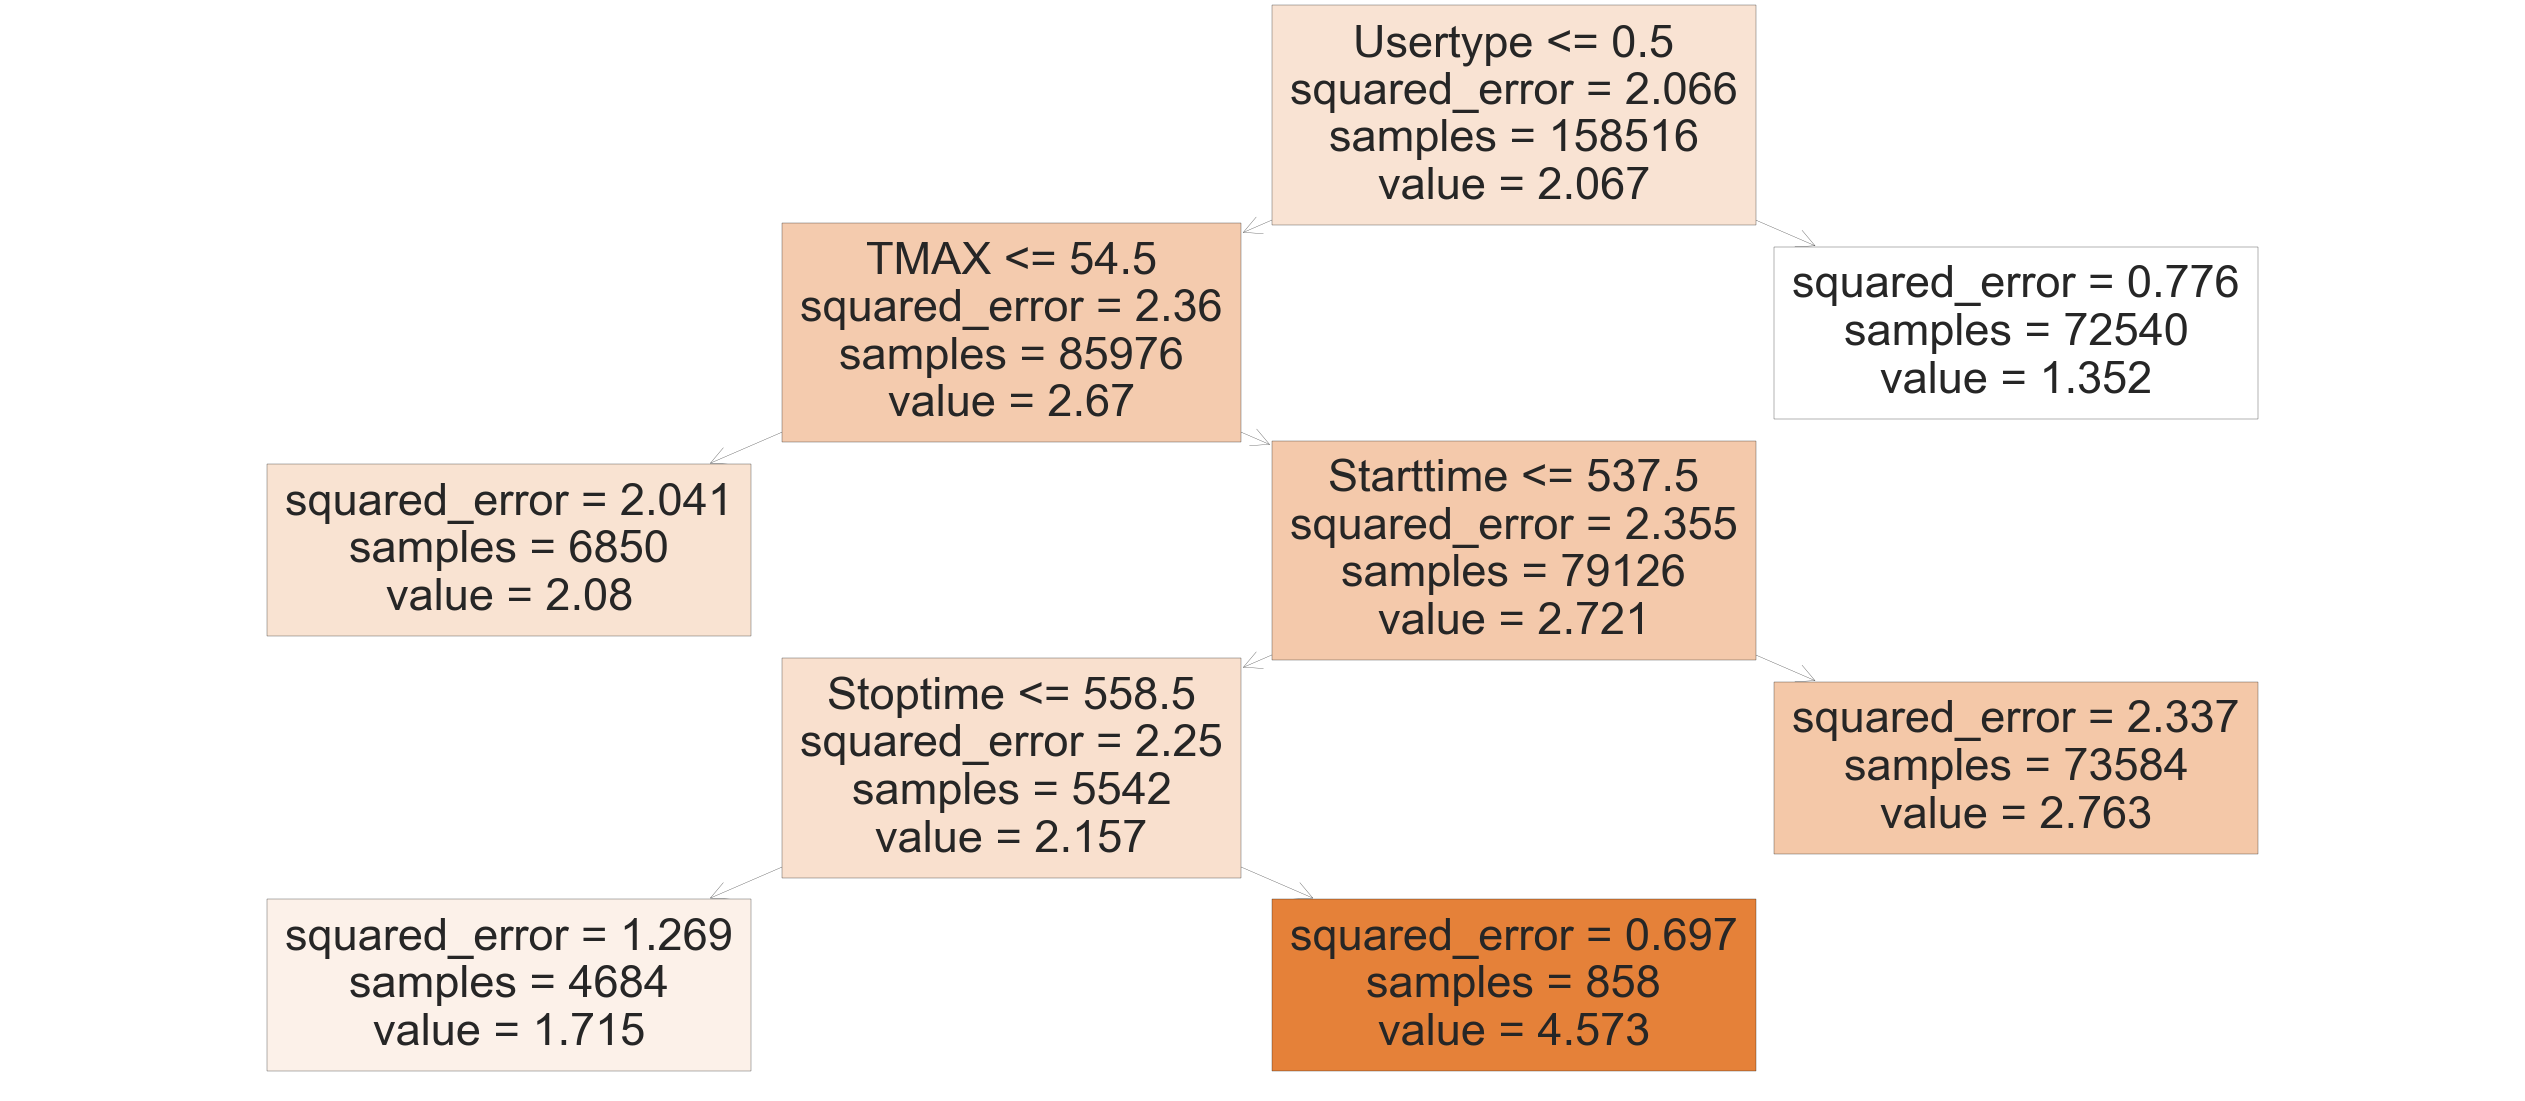

---------------------------------------------------------------------------


In [257]:
# try time interval: 600, 900, 1200
for i in range(600, 1500, 300):
    # split duration into 5 classes
    df_q1['dura_cat'] = df_q1['Tripduration'].apply(lambda x :cat_type(x, i))

    # split X and y
    X_q1 = df_q1.drop(['Tripduration', 'DATE', 'From station id', 'To station id', 'dura_cat'], axis=1)
    y_q1 = df_q1['dura_cat']

    # Set up train and test sets of data, train data is 70 percent of the dataset, and test is 30 percent.
    X_train_q1, X_test_q1, y_train_q1, y_test_q1 = train_test_split(X_q1, y_q1, test_size=0.3, random_state=1)

    # DecisionTree
    reg_tree = DecisionTreeRegressor(max_leaf_nodes=5, random_state=1)
    reg_tree.fit(X_train_q1, y_train_q1)

    # print the result of the tree and cross validation
    print("Time interval for duration is: " + str(i) + " seconds")
    cv_scores = cross_val_score(reg_tree, X_train_q1, y_train_q1, cv=10, scoring='r2')
    print("Mean CV score of %0.2f, with a standard deviation of %0.2f" % (cv_scores.mean(), cv_scores.std()))

    cv_scores = cross_val_score(reg_tree, X_train_q1, y_train_q1, cv=10,scoring='neg_mean_squared_error')
    print("Mean CV score of %0.2f, with a standard deviation of %0.2f" % (cv_scores.mean(), cv_scores.std()))

    test_score = reg_tree.score(X_test_q1,y_test_q1)
    print("Accuracy of test dataset is: " + str(test_score))

    # Plot the generated tree
    fig = plt.figure(figsize=(45,20))
    plot_tree = tree.plot_tree(reg_tree,
                       feature_names=X_q1.columns,
                       filled=True)
    plt.show()

    print("---------------------------------------------------------------------------")

Decision Tree is the worst model for the problem, with accuracy only around 0.3.

### Forth Model: Random Forest

Due to the data quantity, we train the model with 10-50 trees and try to get the best number of trees.
**Due to that we have a very large dataset (200,000+ rows), please allow some time to run the model fitting, thank you**

Time interval for duration is: 600 seconds
The best number of trees is: 40


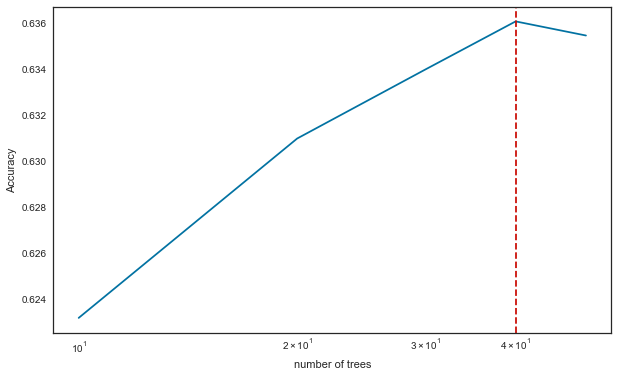

---------------------------------------------------------------------------
Time interval for duration is: 900 seconds
The best number of trees is: 50


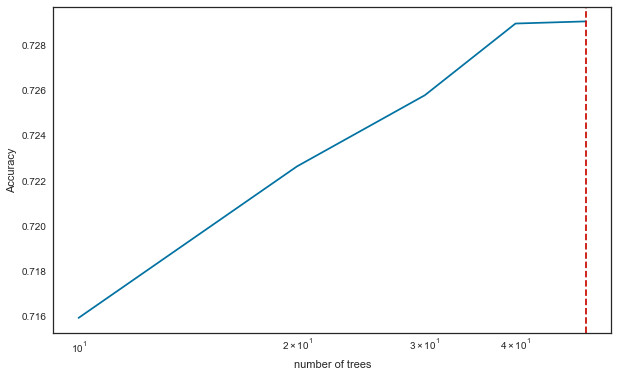

---------------------------------------------------------------------------
Time interval for duration is: 1200 seconds
The best number of trees is: 50


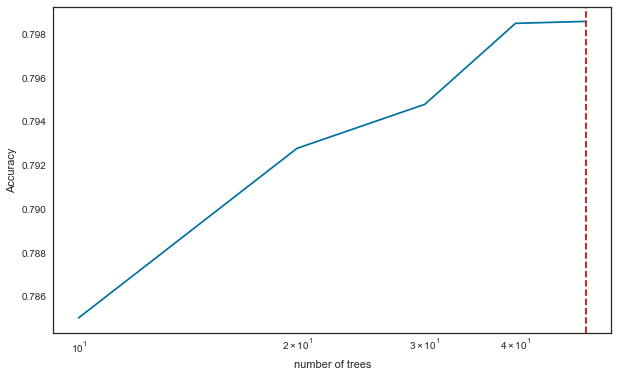

---------------------------------------------------------------------------


In [258]:
# try time interval: 600, 900, 1200
for i in range(600, 1500, 300):
    # split duration into 5 classes
    df_q1['dura_cat'] = df_q1['Tripduration'].apply(lambda x :cat_type(x, i))

    # split X and y
    X_q1_q1 = df_q1.drop(['Tripduration', 'DATE', 'From station id', 'To station id', 'dura_cat'], axis=1)
    y_q1 = df_q1['dura_cat']

    # Set up train and test sets of data, train data is 70 percent of the dataset, and test is 30 percent.
    X_train_q1, X_test_q1, y_train_q1, y_test_q1 = train_test_split(X_q1, y_q1, test_size=0.3, random_state=1)

    # try from 10 to 50 trees with the step size = 10
    trees = range(10, 60, 10)
    # CV_score
    score = []

    for j in trees:
        # Build a RandomForestClassifier
        rf = RandomForestClassifier(random_state=0, n_estimators = j)
        rf.fit(X_train_q1, y_train_q1)
        # calculate the accuracy
        CV_error = np.mean(cross_val_score(rf, X_train_q1, y_train_q1, cv=10, scoring='accuracy'))
        score.append(CV_error)

    print("Time interval for duration is: " + str(i) + " seconds")
    # the best number of trees
    print("The best number of trees is: " + str(trees[score.index(max(score))]))

    # plot the relationship between tree and accuracy
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.plot(trees, score)
    plt.axvline(x=trees[score.index(max(score))], color='r', linestyle='--')
    ax.set_xscale('log')
    plt.xlabel('number of trees')
    plt.ylabel('Accuracy')
    plt.axis('tight')
    plt.show()

    print("---------------------------------------------------------------------------")

Now we use the best number of trees to tune the model.

In [259]:
# try time interval: 600, 900, 1200
for i in range(600, 1500, 300):
    # split duration into 5 classes
    df_q1['dura_cat'] = df_q1['Tripduration'].apply(lambda x :cat_type(x, i))

    # split X and y
    X_q1 = df_q1.drop(['Tripduration', 'DATE', 'From station id', 'To station id', 'dura_cat'], axis=1)
    y_q1 = df_q1['dura_cat']

    # Set up train and test sets of data, train data is 70 percent of the dataset, and test is 30 percent.
    X_train_q1, X_test_q1, y_train_q1, y_test_q1 = train_test_split(X_q1, y_q1, test_size=0.3, random_state=1)

    # set the best number of trees
    if i == 600:
        j = 40
    else:
        j = 50

    # Build a RandomForestClassifier
    rf = RandomForestClassifier(random_state=0, n_estimators = j)
    rf.fit(X_train_q1, y_train_q1)

    print("Time interval for duration is: " + str(i) + " seconds")
    # the best number of trees
    print("The best number of trees is: " + str(j))

    # performance of prediction
    print(classification_report(y_test_q1, rf.predict(X_test_q1)))

    print("---------------------------------------------------------------------------")

Time interval for duration is: 600 seconds
The best number of trees is: 40
              precision    recall  f1-score   support

           1       0.60      0.67      0.63     19797
           2       0.48      0.51      0.49     16831
           3       0.48      0.39      0.43      7752
           4       0.57      0.40      0.47      4433
           5       0.91      0.91      0.91     19123

    accuracy                           0.65     67936
   macro avg       0.61      0.57      0.59     67936
weighted avg       0.65      0.65      0.64     67936

---------------------------------------------------------------------------
Time interval for duration is: 900 seconds
The best number of trees is: 50
              precision    recall  f1-score   support

           1       0.76      0.87      0.81     30155
           2       0.55      0.48      0.51     14225
           3       0.60      0.49      0.54      6203
           4       0.68      0.55      0.61      4403
           5  

Then, we use GridSearchCV to tune two parameters(min_samples_leaf and min_samples_split) of the model after determining the best number of trees.

In [260]:
# try min_samples_leaf

# try time interval: 600, 900, 1200
for i in range(600, 1500, 300):
    # split duration into 5 classes
    df_q1['dura_cat'] = df_q1['Tripduration'].apply(lambda x :cat_type(x, i))

    # split X and y
    X_q1 = df_q1.drop(['Tripduration', 'DATE', 'From station id', 'To station id', 'dura_cat'], axis=1)
    y_q1 = df_q1['dura_cat']

    # Set up train and test sets of data, train data is 70 percent of the dataset, and test is 30 percent.
    X_train_q1, X_test_q1, y_train_q1, y_test_q1 = train_test_split(X_q1, y_q1, test_size=0.3, random_state=1)

    # set the best number of trees
    if i == 600:
        j = 40
    else:
        j = 50

    # try parameter min_samples_leaf from 5 to 51 with the step size = 5
    parameters = {'min_samples_leaf':range(5, 51, 5)}

    # remember to control the random_state = 0 to compare to each other
    rf = RandomForestClassifier(random_state=0, n_estimators = j)

    # train the model
    rf_tuned = GridSearchCV(rf, parameters, scoring = 'accuracy')
    rf_tuned.fit(X_train_q1, y_train_q1)

    print("Time interval for duration is: " + str(i) + " seconds")

    # print the scores and the best params
    print(rf_tuned.cv_results_['mean_test_score'])
    print(rf_tuned.best_params_)

    # rerun the model with the best param
    rf = RandomForestClassifier(random_state=0, n_estimators = j,  min_samples_leaf = rf_tuned.best_params_['min_samples_leaf'])
    rf.fit(X_train_q1, y_train_q1)

    # print the classification_report
    print(classification_report(y_test_q1, rf.predict(X_test_q1)))

    print("---------------------------------------------------------------------------")

Time interval for duration is: 600 seconds
[0.62495901 0.6014093  0.58141135 0.56675672 0.55866918 0.54715617
 0.53957962 0.53408491 0.52656514 0.52467891]
{'min_samples_leaf': 5}
              precision    recall  f1-score   support

           1       0.59      0.76      0.66     19797
           2       0.49      0.48      0.48     16831
           3       0.55      0.24      0.33      7752
           4       0.62      0.18      0.27      4433
           5       0.81      0.92      0.86     19123

    accuracy                           0.64     67936
   macro avg       0.61      0.51      0.52     67936
weighted avg       0.62      0.64      0.61     67936

---------------------------------------------------------------------------
Time interval for duration is: 900 seconds
[0.71322138 0.69046662 0.67389409 0.66249465 0.65402868 0.64377098
 0.63891973 0.63269952 0.6294128  0.62811958]
{'min_samples_leaf': 5}
              precision    recall  f1-score   support

           1       0

In [261]:
# try min_samples_split

# try time interval: 600, 900, 1200
for i in range(600, 1500, 300):
    # split duration into 5 classes
    df_q1['dura_cat'] = df_q1['Tripduration'].apply(lambda x :cat_type(x, i))

    # split X and y
    X_q1 = df_q1.drop(['Tripduration', 'DATE', 'From station id', 'To station id', 'dura_cat'], axis=1)
    y_q1 = df_q1['dura_cat']

    # Set up train and test sets of data, train data is 70 percent of the dataset, and test is 30 percent.
    X_train_q1, X_test_q1, y_train_q1, y_test_q1 = train_test_split(X_q1, y_q1, test_size=0.3, random_state=1)

    # set the best number of trees
    if i == 600:
        j = 40
    else:
        j = 50

    # try parameter min_samples_split from 5 to 51 with the step size = 5
    parameters = {'min_samples_split':range(5, 51, 5)}

    # remember to control the random_state = 0 to compare to each other
    rf = RandomForestClassifier(random_state=0, n_estimators = j)

    # train the model
    rf_tuned = GridSearchCV(rf, parameters, scoring = 'accuracy')
    rf_tuned.fit(X_train_q1, y_train_q1)

    print("Time interval for duration is: " + str(i) + " seconds")

    # print the scores and the best params
    print(rf_tuned.cv_results_['mean_test_score'])
    print(rf_tuned.best_params_)

    # rerun the model with the best param
    rf = RandomForestClassifier(random_state=0, n_estimators = j,  min_samples_split = rf_tuned.best_params_['min_samples_split'])
    rf.fit(X_train_q1, y_train_q1)

    # print the classification_report
    print(classification_report(y_test_q1, rf.predict(X_test_q1)))

    print("---------------------------------------------------------------------------")

Time interval for duration is: 600 seconds
[0.63817534 0.6334187  0.62656132 0.62302231 0.61113074 0.60278459
 0.60054506 0.59698713 0.59459613 0.58313988]
{'min_samples_split': 5}
              precision    recall  f1-score   support

           1       0.61      0.71      0.66     19797
           2       0.50      0.52      0.51     16831
           3       0.53      0.36      0.43      7752
           4       0.61      0.35      0.45      4433
           5       0.89      0.92      0.90     19123

    accuracy                           0.66     67936
   macro avg       0.63      0.57      0.59     67936
weighted avg       0.65      0.66      0.65     67936

---------------------------------------------------------------------------
Time interval for duration is: 900 seconds
[0.72790127 0.72484166 0.71625573 0.71449573 0.70717784 0.69656691
 0.69061798 0.68733124 0.68672566 0.67805773]
{'min_samples_split': 5}
              precision    recall  f1-score   support

           1      

Compared to the result tuned with the best number of trees, the result of 'min_samples_leaf' is a little bit worse and the result of 'min_samples_split' is a little bit better.

Then we plot the importance of features with the best model we got.

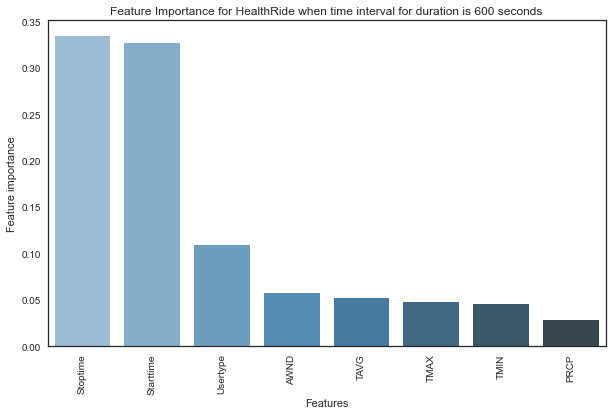

---------------------------------------------------------------------------


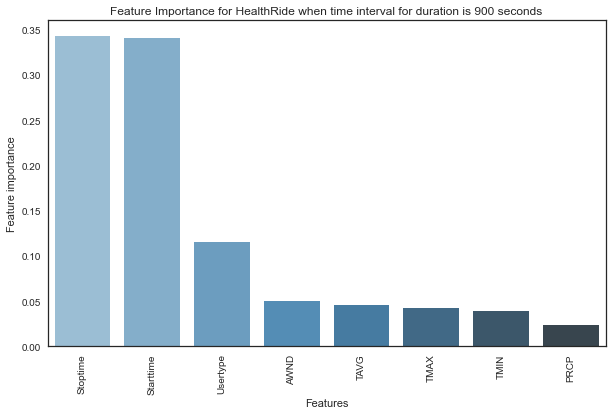

---------------------------------------------------------------------------


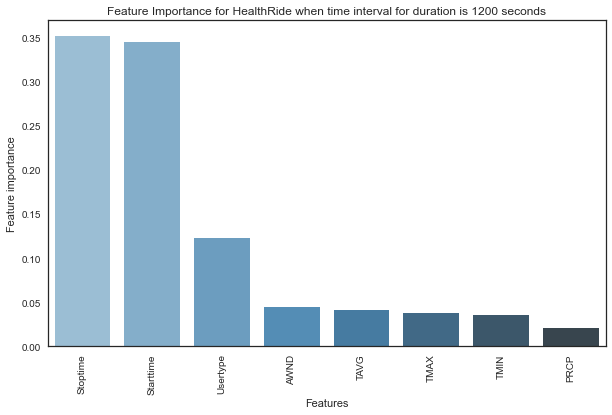

---------------------------------------------------------------------------


In [262]:
# plot the importance of features with best min_samples_split = 5

# try time interval: 600, 900, 1200
for i in range(600, 1500, 300):
    # split duration into 5 classes
    df_q1['dura_cat'] = df_q1['Tripduration'].apply(lambda x :cat_type(x, i))

    # split X and y
    X_q1 = df_q1.drop(['Tripduration', 'DATE', 'From station id', 'To station id', 'dura_cat'], axis=1)
    y_q1 = df_q1['dura_cat']

    # Set up train and test sets of data, train data is 70 percent of the dataset, and test is 30 percent.
    X_train_q1, X_test_q1, y_train_q1, y_test_q1 = train_test_split(X_q1, y_q1, test_size=0.3, random_state=1)

    # set the best number of trees
    if i == 600:
        j = 40
    else:
        j = 50

    # rerun the model with the best param
    rf = RandomForestClassifier(random_state=0, n_estimators = j,  min_samples_split = 5)
    rf.fit(X_train_q1, y_train_q1)

    plt.figure(figsize=(10, 6))
    forest_importances = pd.DataFrame({ 'features': X_q1.columns, 'importances': rf.feature_importances_ })
    sns.barplot(x="features",y="importances" ,data=forest_importances,
                order=forest_importances.sort_values('importances',ascending = False).features, palette="Blues_d")
    plt.xticks(rotation=90)
    plt.title("Feature Importance for HealthRide when time interval for duration is " + str(i) + " seconds")
    plt.ylabel("Feature importance")
    plt.xlabel("Features")
    plt.show()

    print("---------------------------------------------------------------------------")

From the figures, it is obvious that 'Stoptime' and 'Starttime' are most important features; 'Usertype' is also important.

### Q1 implementation summary -- Model comparison

For the 4 models, KNN and Random Forest are the best two models, with the accuracy 0.9 and 0.8; Naive Bayes and Decision Tree are not suitable models for this problem.

In terms of step size of Tripduration, the larger the step size is, the better the performance of model is.

### Q1 implementation conclusions and suggestions:

More than 50% of people usually ride for less than 20 minutes in one trip, and about 20% of people can ride for 30-40 minutes. The rest of them ride for longer time and some of them forget to return the bikes.

In order to better serve the customers, we suggest HealthRide set a station in every 15 minute-ride. In this way, when people feel tired to ride, they can easily find a nearby station to return the bike.
In addition, HealthyRide may consider setting time recording system: when the bike is in use for over 1 hour, it can give out a alert to remind the user of returning the bike.

# Second question Q2 analysis: How can we determine usertypes based on other features?

Declare and use a new df_merged set called df_merged_q2

In [263]:
df_merged_q2 = df_merged

In [264]:
X_q2 = df_merged_q2.drop(['Usertype', 'DATE'], axis=1)
y_q2 = df_merged_q2['Usertype']

In [265]:
# Reset train and test sets
X_train_q2, X_test_q2, y_train_q2, y_test_q2 = train_test_split(X_q2.to_numpy(),
                                                    y_q2.to_numpy(),
                                                    test_size=0.3,
                                                    random_state=1)
labels=['0','1']

### Q2 Implementation: Data exploration: Visualization

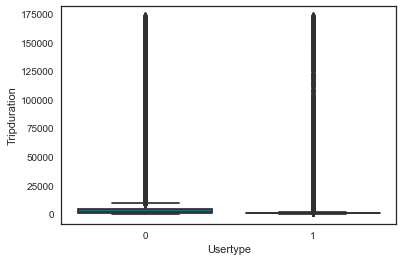

In [266]:
# Boxplot of Disribution of tripduration of different usertypes
sns.boxplot(x='Usertype', y='Tripduration',data=df_merged_q2)
plt.show()

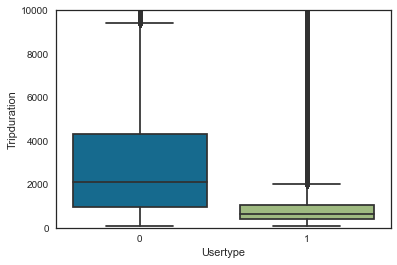

In [267]:
# Boxplot of Disribution of tripduration of different usertypes
## Zoom in a little bit to look clearer
sns.boxplot(x='Usertype', y='Tripduration',data=df_merged_q2)
plt.ylim(0, 10000)
plt.show()

This box plot shows that customer generally spend more time than subscribers!

### First Model: KNN

In [268]:
# first start with the default number of neighbors

# create a knn object and fit X_train and y_train to it
knn_merged_q2 = KNeighborsClassifier().fit(X_train_q2, y_train_q2)
y_pred_q2 = knn_merged_q2.predict(X_test_q2)
cm_merged_q2 = confusion_matrix(y_test_q2,y_pred_q2)

print(cm_merged_q2)

# print the classification report to see the accuracy of the model and how well it classifies the 2 classes
print(classification_report(y_test_q2, y_pred_q2, digits=3))

[[27889  8659]
 [ 8916 22472]]
              precision    recall  f1-score   support

           0      0.758     0.763     0.760     36548
           1      0.722     0.716     0.719     31388

    accuracy                          0.741     67936
   macro avg      0.740     0.740     0.740     67936
weighted avg      0.741     0.741     0.741     67936



------------
k = 1
Accuracy (CV_error):  0.6692851781312876
------------
k = 2
Accuracy (CV_error):  0.6673245591858035
------------
k = 3
Accuracy (CV_error):  0.7032658727109136
------------
k = 4
Accuracy (CV_error):  0.696615491592769
------------
k = 5
Accuracy (CV_error):  0.7166726897833108
------------
k = 6
Accuracy (CV_error):  0.7112322813832032
------------
k = 7
Accuracy (CV_error):  0.7241753762592146
------------
k = 8
Accuracy (CV_error):  0.7198521894688429
------------
k = 9
Accuracy (CV_error):  0.7288121214463584
------------
k = 10
Accuracy (CV_error):  0.7257253906141912
------------
k = 11
Accuracy (CV_error):  0.7323448801113267
------------
k = 12
Accuracy (CV_error):  0.7295981762910465
------------
k = 13
Accuracy (CV_error):  0.7349856279608541
------------
k = 14
Accuracy (CV_error):  0.7320181176321057
------------
k = 15
Accuracy (CV_error):  0.7366946000620452
------------
k = 16
Accuracy (CV_error):  0.7350342160904555
------------
k = 17
Accuracy (CV_e

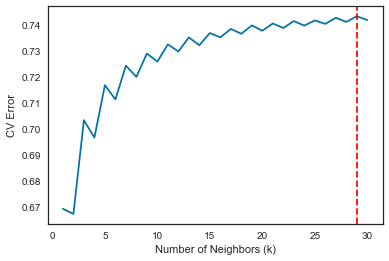

In [269]:
# Use cross validation to determine what is the optimal number of neighbors for the KNN model

# try n_neighbors from 1 to 30
k_range = range(1, 31)
knn_cverrs = []

for k in k_range:
    knn_merged_q2 = KNeighborsClassifier(n_neighbors=k)
    # caculate cv score
    CV_error_q2 = np.mean(cross_val_score(knn_merged_q2, X_q2, y_q2, cv=10,scoring='accuracy'))
    # append cv score into the empty list
    knn_cverrs.append(CV_error_q2)
    print("------------")
    print("k =",k)
    print("Accuracy (CV_error): ",CV_error_q2)

# Plot a graph of # neighbors vs accuracy of the model
plt.plot(k_range, knn_cverrs)
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("CV Error")
plt.axvline(x=k_range[knn_cverrs.index(max(knn_cverrs))],linestyle='--',color="red")
plt.show()

In [270]:
# use the optimal n_neighbor=29 to retrain the KNN model

# create a new object and fit in X_train and y_train
knn_merged_new = KNeighborsClassifier(n_neighbors=29)
knn_merged_new.fit(X_train_q2, y_train_q2)
y_pred_new = knn_merged_new.predict(X_test_q2)
cm_merged_new = confusion_matrix(y_test_q2,y_pred_q2)


print(cm_merged_new)

# print the classification report
print(classification_report(y_test_q2, y_pred_new, digits=3))

[[27889  8659]
 [ 8916 22472]]
              precision    recall  f1-score   support

           0      0.784     0.756     0.770     36548
           1      0.728     0.758     0.742     31388

    accuracy                          0.757     67936
   macro avg      0.756     0.757     0.756     67936
weighted avg      0.758     0.757     0.757     67936



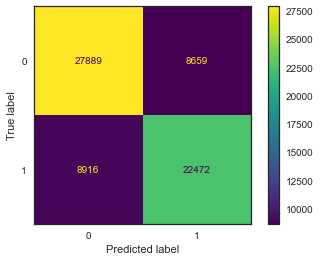

In [271]:
# display the confusion matrix

dissplay_cm = ConfusionMatrixDisplay(confusion_matrix=cm_merged_new,
                                           display_labels=labels)
dissplay_cm.plot()

### Second Model: Naive Bayes classifier

In [272]:
# create a naive bayes classifier
modelNB = GaussianNB()
# calculate cv score of the model after fit in it
CV_error = np.mean(cross_val_score(modelNB, X_q2, y_q2, cv=10))
print("Accuracy: ",CV_error)

Accuracy:  0.6351236081166858


              precision    recall  f1-score   support

           0      0.689     0.698     0.693     36548
           1      0.643     0.634     0.638     31388

    accuracy                          0.668     67936
   macro avg      0.666     0.666     0.666     67936
weighted avg      0.668     0.668     0.668     67936



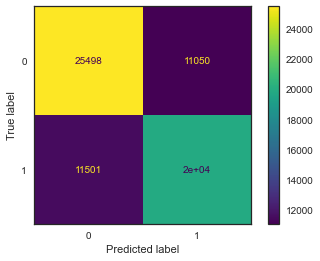

In [273]:
# use training set to train the naive bayes classifier
modelNB.fit(X_train_q2, y_train_q2)
y_pred_q2_NB = modelNB.predict(X_test_q2)

# display confusion matrix and print the classification report to see the accuracy of the model
cm_bikes = confusion_matrix(y_test_q2,y_pred_q2_NB)
print(classification_report(y_test_q2, y_pred_q2_NB, digits=3))

dissplay_cm_bikes = ConfusionMatrixDisplay(confusion_matrix=cm_bikes,display_labels=labels)
dissplay_cm_bikes.plot()

### Third Model: DecisionTree

In [274]:
# create a decision tree classifier
clf_q2 = DecisionTreeClassifier(max_leaf_nodes=5)
# fit X_train and y_train in the model
clf_q2.fit(X_train_q2, y_train_q2)

DecisionTreeClassifier(max_leaf_nodes=5)

In [275]:
# display classification report of the model to see its accuracy and how well it classifies the 2 classes
print(classification_report(y_test_q2, clf_q2.predict(X_test_q2)))

              precision    recall  f1-score   support

           0       0.83      0.64      0.72     36548
           1       0.67      0.85      0.75     31388

    accuracy                           0.74     67936
   macro avg       0.75      0.74      0.74     67936
weighted avg       0.76      0.74      0.74     67936



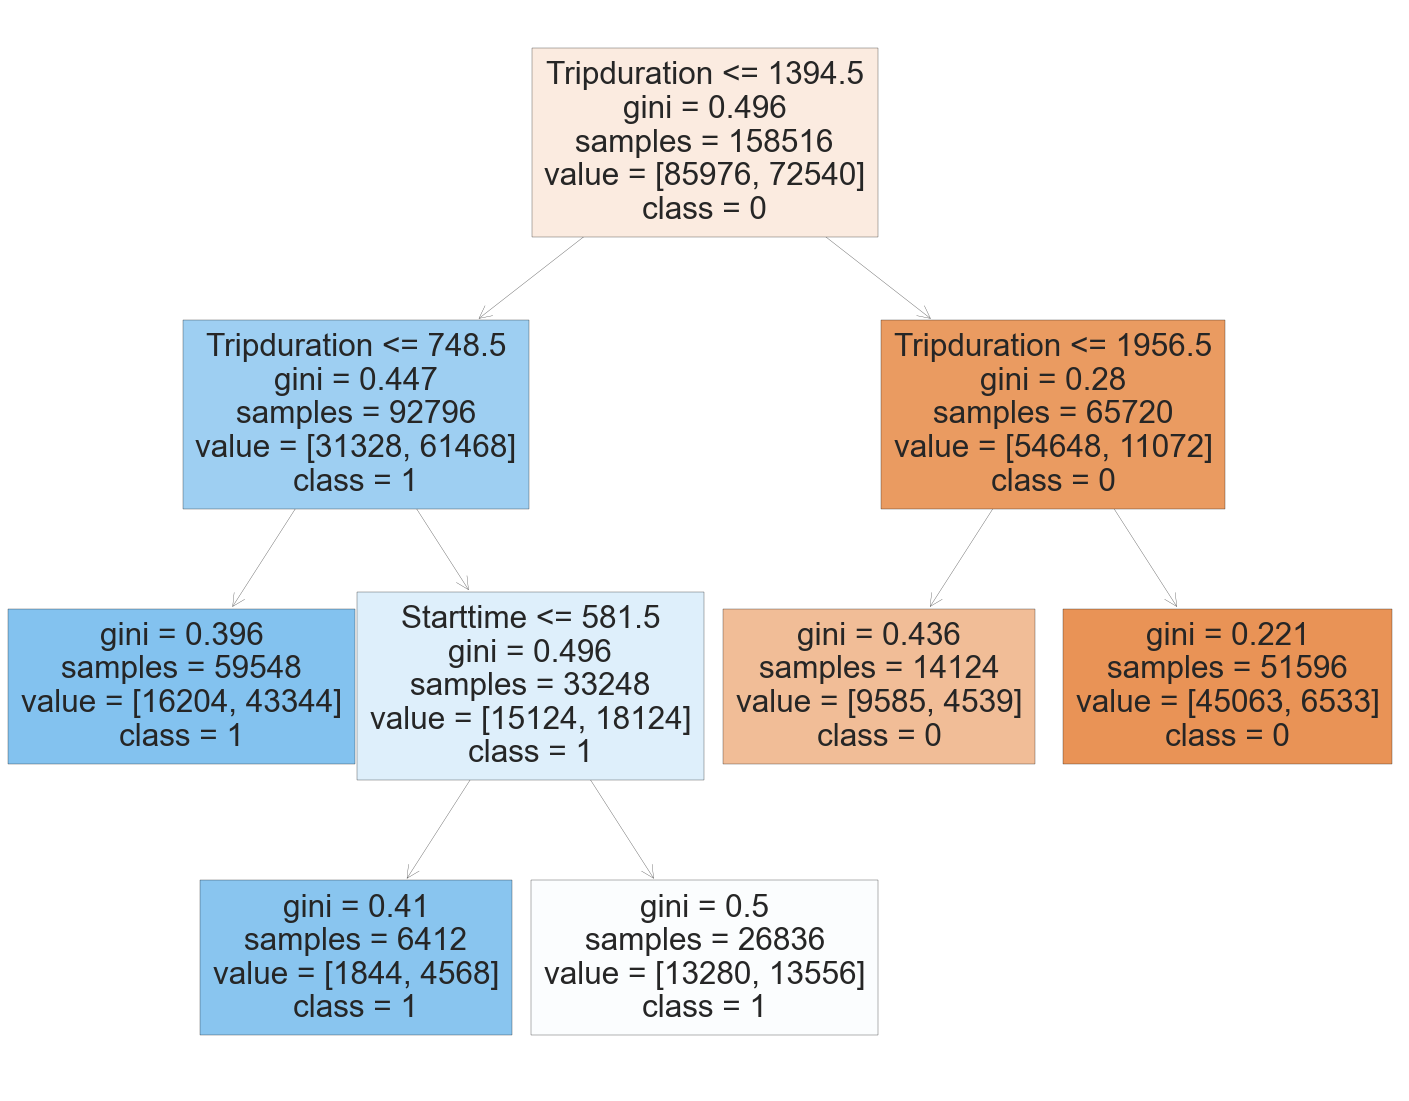

In [276]:
# visilize the decision tree
fig = plt.figure(figsize=(25,20))
plot_tree = tree.plot_tree(clf_q2,
                           feature_names=X_q2.columns,
                           class_names=labels,
                           filled=True)
plt.show()

### Forth Model: random forest classifier

In [277]:
# create a random forest classifier object and fit into it
rf_q2 = RandomForestClassifier(random_state=1)
rf_q2.fit(X_train_q2, y_train_q2)
rf_pred_q2 = rf_q2.predict(X_test_q2)

# print the r squared for the model
rf_q2.score(X_test_q2, y_test_q2)

0.7936587376354216

In [278]:
# Print a classification report with the previous RandomForest Classifier
print(classification_report(y_test_q2, rf_q2.predict(X_test_q2)))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81     36548
           1       0.77      0.79      0.78     31388

    accuracy                           0.79     67936
   macro avg       0.79      0.79      0.79     67936
weighted avg       0.79      0.79      0.79     67936



### From the 4 classification reports above, we know that random forest classifier is the best model for our dataset.

Due to a very large dataset, we will run a 100 stepwise loop instead of 20 to reduce time of computation for randomforest significantly.

In [279]:
# tune the number of trees (n_estimators) in the RF
total_trees = []
cv_score = []

# set step size 100
for i in range (10, 210, 100):
    # create an object and fit into it
    rf_q2_1 = RandomForestClassifier(n_estimators=i, random_state=1)
    rf_q2_1.fit(X_train_q2, y_train_q2)
    rf_pred_q2_1 = rf_q2_1.predict(X_test_q2)
    # calculate cv score
    scores = np.mean(cross_val_score(rf_q2_1, X_train_q2, y_train_q2, cv=10, scoring='accuracy'))
    # append the absolute values of the cv scores to the empty list created above
    cv_score.append(abs(scores))
    total_trees.append(i)

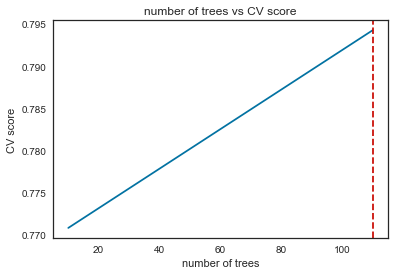

In [280]:
# plot the number of trees vs CV score to find the best number of trees
plt.plot(total_trees, cv_score)
plt.axvline(x=total_trees[cv_score.index(max(cv_score))], color='r', linestyle='--')
plt.xlabel('number of trees')
plt.ylabel('CV score')
plt.title('number of trees vs CV score')
plt.show()

In [281]:
# after we determine the best number of trees is 200
# we tune the random forest classifier again

rf_q2_tuned = RandomForestClassifier(random_state=1, n_estimators = 200)
rf_q2_tuned.fit(X_train_q2, y_train_q2)

# Print a classification report with the previous RandomForest Classifier
print(classification_report(y_test_q2, rf_q2_tuned.predict(X_test_q2)))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     36548
           1       0.77      0.79      0.78     31388

    accuracy                           0.79     67936
   macro avg       0.79      0.79      0.79     67936
weighted avg       0.80      0.79      0.79     67936



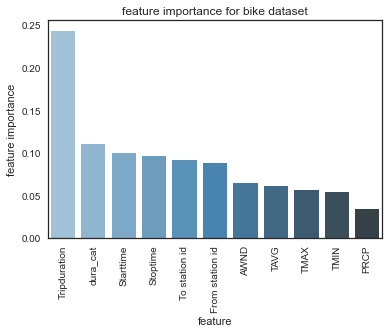

In [282]:
feature_importances = pd.DataFrame({'features': X_q2.columns, 'importances': rf_q2_tuned.feature_importances_})
sns.barplot(x="features",y="importances", data=feature_importances,
            order=feature_importances.sort_values('importances',ascending = False).features, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("feature importance for bike dataset")
plt.ylabel("feature importance")
plt.xlabel("feature")
fig.tight_layout()

### Q2 implementation summary:

Based on the plot, we can conclude that trip duration is the most important feature for determining user types, and the seond important variable is starttime, following by stoptime which is the third.

### Q2 implementation conclusions:

For the HealthyRide organization, it is likely that it wants to distinguish subscribers from customers. In this sense, knowing what features can be used to determine usertypes is important. We would suggest that the HealthyRide organization to focus on users top three important features and implement targeted measures on the top three features to accommodate different types of users.

Also, there are implications combine with conclusion from Question 1 that the longer trip duration is caused by customers who forget to return the ride share. This might cost trouble to the ride share company since they might lose revenue due to this. How does the organization control the trip duration, and promote customer to subscribe to this service are key to generate more revenue and profit.

# Third question Q3 analysis: What is the influence of weather on trip duration? Weather is examined by average temperature, precipitation, and average wind speed.

Firstly, we create new dataset for q3 and drop DATE

In [291]:
df_q3 = df_merged
df_q3 = df_merged.drop(['DATE', 'dura_cat'], axis=1)

### Process 3.2 -- Create scatter plot visualization for weather and trip duration
This can visually help to understand the distribution of the data of weather and trip duration

Text(0.5, 1.0, 'Scatterplot of average temperature and trip duration')

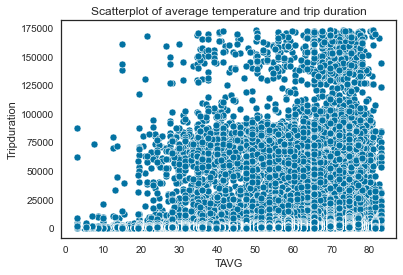

In [292]:
# Create scatterplot of average temperature and trip duration
sns.scatterplot(data=df_q3, x='TAVG', y='Tripduration').set_title('Scatterplot of average temperature and trip duration')

Text(0.5, 1.0, 'Scatterplot of average precipitation and trip duration')

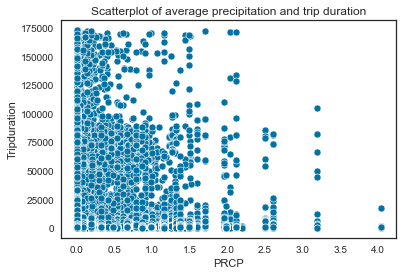

In [293]:
# Create scatterplot of precipitation and trip duration
sns.scatterplot(data=df_q3, x='PRCP', y='Tripduration').set_title('Scatterplot of average precipitation and trip duration')

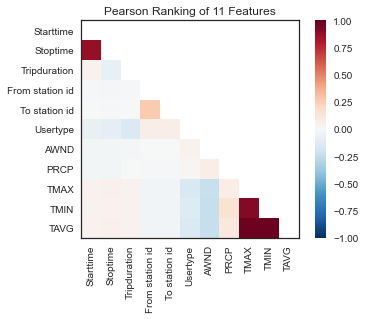

<AxesSubplot:title={'center':'Pearson Ranking of 11 Features'}>

In [294]:
# Create an 2D Pearson ranking graph for all the features in X
# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson')

visualizer.fit(df_q3)           # Fit the data to the visualizer
visualizer.transform(df_q3)        # Transform the data
visualizer.show()

From the avove Pearson ranking graph for all features, we are able to briefly see the correlation between Tripduration and weather variables (AWND, PRCP, and TAVG). The correlaiton between Tripduration and average wind speed is hitting 0, which indicates not a strong correlation. The correlation between Tripduration and Precipitation is slightly negative, which makes sense, since we expect to see less trips and tripduration if rain more. The correlation between Tripduration and average temperature is positive, which makes sense, since we expect the higher temperatures, more trip duration should be spent since it is not cold.

After knowing this information, now we will perform K-means Clustering by choosing the optimal k.

### Process 3.3 -- Find the optimal K for K-means clustering
Find the optimal K using both of elbow method and Calinski-Harabasz metrics, compare two of them, and decide which one is more optimal

In [295]:
# Create a Kmeans model
model = KMeans(random_state=1)
model.fit(df_q3)

KMeans(random_state=1)

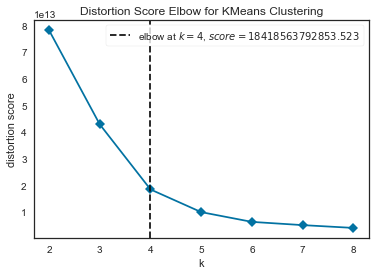

In [296]:
# Run an elbow method from k=2 to k=8 to see which k is the best using elbow method
visualizer = KElbowVisualizer(model, k=(2,9), timings = False)
visualizer.fit(df_q3.values)
visualizer.show();

As shown in the graph above, k = 4 is the optimal k using elbow method.

In [297]:
# Build and fit the K-means clustering using k = 4
model_elbow = KMeans(random_state=1, n_clusters=4).fit(df_q3.values)

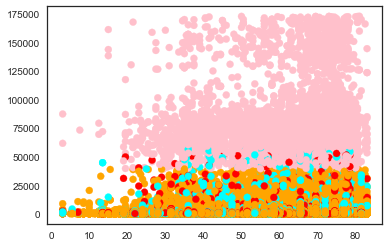

In [298]:
# Create scatterplot of the clustering using varibales TAVG and Triptime to see if that gives insights
colors = np.array(["orange", "red","pink","cyan","purple"])
plt.scatter(df_q3['TAVG'], df_q3['Tripduration'], c=colors[model_elbow.labels_])
plt.show()

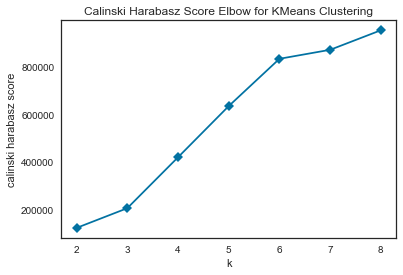

The best k using Calinski Harabasz method is 8


In [299]:
# Run a Calinski Harabasz method from k=2 to k=8 to see which k is the best using Calinski Harabasz method
visualizer = KElbowVisualizer(model, k=(2,9), metric='calinski_harabasz',timings=False, locate_elbow=False)
visualizer.fit(df_q3)
visualizer.show();
# Print out the index of which the Calinski Harabasz score is the highest
print('The best k using Calinski Harabasz method is', visualizer.k_scores_.index(max(visualizer.k_scores_)) + 2)

In [300]:
# Build and fit the K-means clustering using k = 8
model_calinski = KMeans(random_state=1, n_clusters=8).fit(df_q3.values)

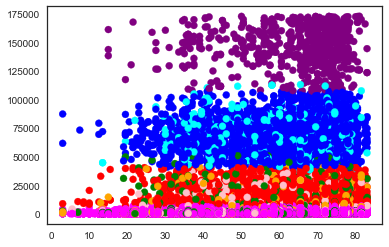

In [301]:
# Create scatterplot of the clustering using varibales TAVG and Triptime to see if that gives insights
colors = np.array(["red","green","blue","pink","orange","magenta","purple","cyan", "yellow", "grey", "black", "brown", "wheat", "teal", "lime", "olive", "indigo", "gold", "salmon", "seagreen"])
plt.scatter(df_q3['TAVG'], df_q3['Tripduration'], c=colors[model_calinski.labels_])
plt.show()

After finding the best k using elbow and Calinski method, now we need to compare and see which method is better. To conduct model validation, there are 2 plots we can reference and compare, the first one is Sillhouette plot, the second one is Interclusterdistance map. However, the Sillhouette plot takes a very long time (1hr+) to run with 200,000 rows of data, therefore, in this case, for the time convenience, we sample 1/10 of the population data to run Sillhouette, since the smaple is large enough, the Sillouette plot is expected to be very similar for the sample and the population.

In [302]:
# Sample data
df_q3_sample = df_q3.sample(frac=0.1, random_state=1, replace = False)

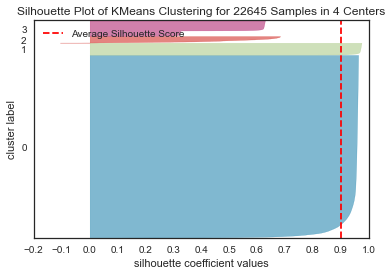

In [303]:
# Create a Sillhouette plot for elbow method which K = 4
visualizer = SilhouetteVisualizer(model_elbow, colors='yellowbrick')
visualizer.fit(df_q3_sample.values)
visualizer.show();

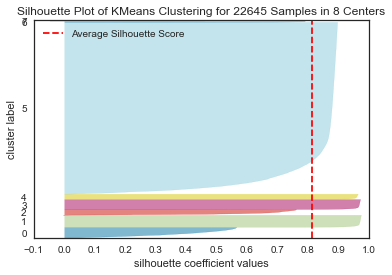

In [304]:
# Create a Sillhouette plot for elbow method which K = 8
visualizer = SilhouetteVisualizer(model_calinski, colors='yellowbrick')
visualizer.fit(df_q3_sample.values)
visualizer.show();

Comparing the Silhouette plot for k = 4 and k = 8, we are able to see that k = 8 performs better. There is no negitive coefficient values for clusters in k = 8, whereas there is a tail for k = 4. Also, K = 4 has a cluster which has so big of an area whereas k = 8 is smaller, therefore, k = 8 performs better for Silhouette plot.

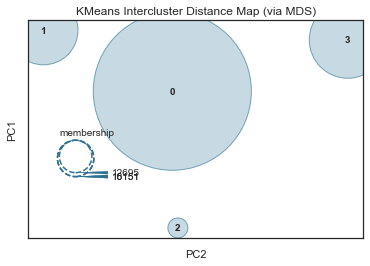

In [305]:
# Create an Intercluster Distance Map for elbow method which K = 4
visualizer = InterclusterDistance(model_elbow, random_state=1)
visualizer.fit(df_q3)
visualizer.show();

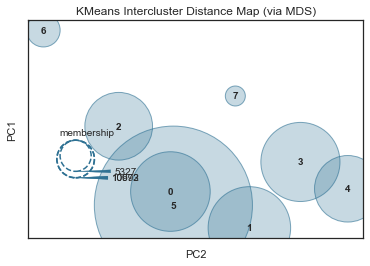

In [306]:
# Create an Intercluster Distance Map for Calinski method which K = 8
visualizer = InterclusterDistance(model_calinski, random_state=1)
visualizer.fit(df_q3)
visualizer.show();

Comparing the InterClusterDistance map between k = 4 and k = 8, we are able to see that both PC1 and PC2 for K = 4 and K = 8 are positive, which is good. K=4 is slightly better in terms of overlapping. There is no Cluster distance overlaps in k = 4, whereas the cluster distance overlaps for k = 8. However, the k = 4 map has a very large clustering, and the reason why k = 4 does not overlap is because it has fewer clusters.

Based on both plots on K = 4 and K = 8, we are able to pick that K = 8 is a better performace clustering

### Process 3.4 -- display the clustering result of tripduration and weather variables using the optimal k

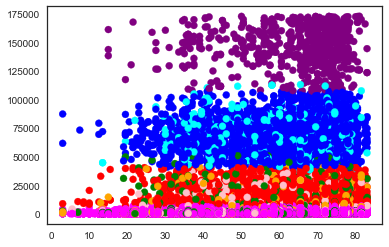

In [307]:
# Create scatterplot of the clustering using TAVG and Tripduration
colors = np.array(["red","green","blue","pink","orange","magenta","purple","cyan", "yellow", "grey", "black", "brown", "wheat", "teal", "lime", "olive", "indigo", "gold", "salmon", "seagreen"])
plt.scatter(df_q3['TAVG'], df_q3['Tripduration'], c=colors[model_calinski.labels_])
plt.show()

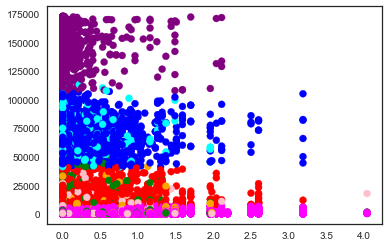

In [308]:
# Create scatterplot of the clustering using varibales PRCP and Tripduration
plt.scatter(df_q3['PRCP'], df_q3['Tripduration'], c=colors[model_calinski.labels_])
plt.show()

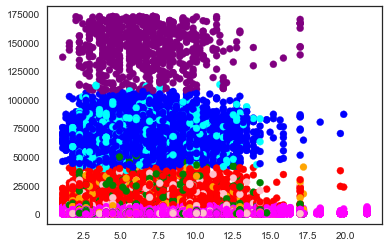

In [309]:
# Create scatterplot of the clustering using varibales AWND and Tripduration
plt.scatter(df_q3['AWND'], df_q3['Tripduration'], c=colors[model_calinski.labels_])
plt.show()

### Q3 implementation summary

From the previous 3 plots, we examine the plot for trip duration and average temperature, precipitation, and average wind speed using cluster number equals to 8. We believe that this is the optimal clustering for this dataset.

For the trip duration vs. temperature, we are able to see that as the average temperature gets higher, more duration will be spent on trip. So the higher the temperature, the trip will be longer.
For the trip duration vs. average wind speed, we are able to see that there are less trip duration when the wind speed is higher. People generally stop riding when the wind speed gets very high.
For the trip duration vs. precipitation, we are able to see that rain is significantly negative impacted to trip duration, when there is more rain and precipitation in a day, the trip duration siginificantly drops.

### Q3 implementation conclusions and suggestions:

From this question's analysis, we are able to see that as significant correlations between tripduration and weather aspects. Generally, warmer temperature, less wind, and less raining will lead to a higher trip duration. Therefore, what should we do when the temperature is low, when the wind is high, and when it is raining?

We recommend the rideshare company to consistently monitor weather condition in Pittsburgh, so that when the weather condition gets worse (raining, windy, and low temperature condition), there ought to be promotions that could incentivize customers' willingness to use the service of the healthy rideshare.

# Implementation -- Conclusion: overall

In conclusion, in terms of user behavior, more than 50% of people usually ride for less than 20 minutes in one trip, and about 20% of people can ride for 30-40 minutes. Also, analyzing about the subscription, the most determining variable for usertype is trip duration, and suprisingly the longer the trip duration, it is more likely to be an un-subscribed customers. The healthy ride share organization should think about how to use this to promote customer to subscribe to this service. They should give advertisement during the typically long ride share. Lastly, the weather also have significant effects on trip time, users generally more like to ride on warmer, less rainy, and less windy weather. It is important that the organizaiton is aware of this situation and give promotions during bad weather conditions.

# Implementation -- Future work

### Improvements on models
- In Question 1, since the prediction models perform poorly, we turn the problem into a classification problem and manually divide the data into 5 classes. We can generally draw reasonable conclusions but the step size really matters. So in the next step, we may try to solve the problem from another perspective, maybe less dependent on intervention.
- In Question 2, Use smaller step size to find the best number of trees when fitting the Random Forest Classifier.
- In Question 3, use other unsupervised learning models other than K-means clustering to train the datasets and gain more insights other than the K-means clustering model.
### Include data of more years to improve accuracy
- This analysis uses data from 2017 to 2019, to improve accuracy, and to see the impact from Covid-19, we will include the healthy ride share data for 2020 and 2021 in the future.

# Reference
1. [National Centers for Environmental Information](https://www.ncdc.noaa.gov/cdo-web/search)
2. [Western Pennsylvania Regional Data Center](https://data.wprdc.org/dataset/healthyride-trip-data)
3. Data Mining Homework 1 answer
4. Data Mining Homework 2 answer
5. Data Mining Homework 3
6. Data Mining Lab 2 answer
7. Data Mining Lab 3 answer
8. Data Mining Lab 4
9. Data Mining In-class practice
10. [pandas.DataFrame.sample](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html)
11. [Why is sklearn.metrics.silhouette_score so slow for sparse matrix input?](https://stackoverflow.com/questions/59118095/why-is-sklearn-metrics-silhouette-score-so-slow-for-sparse-matrix-input)
12. [Selecting the number of clusters with silhouette analysis on KMeans clustering](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
13. [sklearn.cluster.AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)
14. [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)
15. [SKLearn warnings in version 1.0](https://stackoverflow.com/questions/69326639/sklearn-warnings-in-version-1-0)